# Profiling

In [1]:
%load_ext autoreload
%autoreload 2
import sys
from pathlib import Path
sys.path.insert(1, str(Path.cwd().parent))
str(Path.cwd().parent)

'/home/ximo/GitHub/skforecast'

In [2]:
import platform
import psutil
import skforecast
import pandas as pd
import numpy as np
import scipy
import sklearn

import numpy as np
import pandas as pd
from sklearn.linear_model import Ridge
from sklearn.preprocessing import StandardScaler
from lightgbm import LGBMRegressor

from skforecast.recursive import ForecasterRecursiveMultiSeries
from skforecast.model_selection import grid_search_forecaster_multiseries
from skforecast.model_selection import bayesian_search_forecaster_multiseries
from skforecast.model_selection import backtesting_forecaster_multiseries
from skforecast.utils import *

from sklearn.preprocessing import OrdinalEncoder
from sklearn.compose import make_column_transformer
from skforecast.preprocessing import series_long_to_dict
from skforecast.preprocessing import exog_long_to_dict
from skforecast.datasets import fetch_dataset

%load_ext pyinstrument
%load_ext line_profiler

# Information system and libraries

In [3]:
# Versions
# ==============================================================================
print(f"Python version: {platform.python_version()}")
print(f"scikit-learn version: {sklearn.__version__}")
print(f"skforecast version: {skforecast.__version__}")
print(f"pandas version: {pd.__version__}")
print(f"numpy version: {np.__version__}")
print(f"scipy version: {scipy.__version__}")
print(f"psutil version: {psutil.__version__}")
print("")

# Computer information
# ==============================================================================
#Computer network name
print(f"Computer network name: {platform.node()}")
#Machine type
print(f"Machine type: {platform.machine()}")
#Processor type
print(f"Processor type: {platform.processor()}")
#Platform type
print(f"Platform type: {platform.platform()}")
#Operating system
print(f"Operating system: {platform.system()}")
#Operating system release
print(f"Operating system release: {platform.release()}")
#Operating system version
print(f"Operating system version: {platform.version()}")
#Physical cores
print(f"Number of physical cores: {psutil.cpu_count(logical=False)}")
#Logical cores
print(f"Number of logical cores: {psutil.cpu_count(logical=True)}")

Python version: 3.12.9
scikit-learn version: 1.6.1
skforecast version: 0.16.0
pandas version: 2.2.3
numpy version: 2.0.2
scipy version: 1.15.2
psutil version: 5.9.0

Computer network name: ximo
Machine type: x86_64
Processor type: x86_64
Platform type: Linux-6.8.0-57-generic-x86_64-with-glibc2.39
Operating system: Linux
Operating system release: 6.8.0-57-generic
Operating system version: #59-Ubuntu SMP PREEMPT_DYNAMIC Sat Mar 15 17:40:59 UTC 2025
Number of physical cores: 4
Number of logical cores: 8


# ForecasterAutoregMultiSeries

In [4]:
n_series = 200
len_series = (2000, 5000)
series_dict = {}
rng = np.random.default_rng(321)
for i in range(n_series):
    n = rng.integers(low=len_series[0], high=len_series[1])
    series_dict[f'series_{i}'] = pd.Series(
        data = rng.normal(loc=20, scale=5, size=n),
        index=pd.date_range(
            start='2010-01-01',
            periods=n,
            freq='h'
        ),
        name=f'series_{i}'
    )

exog_dict = {}
rng = np.random.default_rng(321)
for k in series_dict.keys():
    exog = pd.DataFrame(
            index=series_dict[k].index
            )
    exog['day_of_week'] = exog.index.dayofweek
    exog['week_of_year'] = exog.index.isocalendar().week.astype(int)
    exog['month'] = exog.index.month
    exog_dict[k] = exog


print(f"Range of dates: "
    f"{np.min([series_dict[k].index.min() for k in series_dict.keys()])} - "
    f"{np.max([series_dict[k].index.max() for k in series_dict.keys()])}"
)

Range of dates: 2010-01-01 00:00:00 - 2010-07-27 09:00:00


In [5]:
end_train = '2010-06-01 00:00:00'

In [6]:
# Forecaster
# ==============================================================================
forecaster = ForecasterRecursiveMultiSeries(
    regressor=LGBMRegressor(random_state=8520, verbose=-1),
    lags=50,
    # transformer_series=StandardScaler(),
    # transformer_exog=StandardScaler(),
    encoding="ordinal"
)

In [7]:
%%timeit

forecaster.fit(series=series_dict, exog=exog_dict)

5.85 s ± 263 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


_     ._   __/__   _ _  _  _ _/_   Recorded: 09:14:43  Samples:  1137
 /_//_/// /_\ / //_// / //_'/ //     Duration: 5.501     CPU time: 17.430
/   _/                      v5.0.1

Cell [8]

5.500 <module>  /tmp/ipykernel_8030/3804324935.py:1
`- 5.500 ForecasterRecursiveMultiSeries.fit  skforecast/recursive/_forecaster_recursive_multiseries.py:1637
   |- 3.821 LGBMRegressor.fit  lightgbm/sklearn.py:1381
   |     [12 frames hidden]  lightgbm, pandas
   |        2.677 Booster.update  lightgbm/basic.py:4092
   |- 0.691 ForecasterRecursiveMultiSeries._create_train_X_y  skforecast/recursive/_forecaster_recursive_multiseries.py:961
   |  |- 0.235 ForecasterRecursiveMultiSeries._create_train_X_y_single_series  skforecast/recursive/_forecaster_recursive_multiseries.py:836
   |  |  |- 0.130 ForecasterRecursiveMultiSeries._create_lags  skforecast/recursive/_forecaster_recursive_multiseries.py:724
   |  |  |  `- 0.073 full  numpy/_core/numeric.py:300
   |  |  `- 0.058 DataFrame.__setitem__  pandas/core/frame.py:4271
   |  |     `- 0.056 DataFrame._set_item  pandas/core/frame.py:4514
   |  |- 0.175 concat  pandas/core/reshape/concat.py:157
   |  |     [8 frames hidden]  pandas, <built-in>
   |  |- 0.090 OrdinalEncoder.wrapped  sklearn/utils/_set_output.py:317
   |  |     [6 frames hidden]  sklearn
   |  `- 0.071 check_preprocess_exog_multiseries  skforecast/utils/utils.py:2495
   |- 0.456 LGBMRegressor.predict  lightgbm/sklearn.py:1093
   |     [9 frames hidden]  lightgbm, pandas
   |- 0.187 Series.__getitem__  pandas/core/series.py:1095
   |     [5 frames hidden]  pandas
   |- 0.155 [self]  skforecast/recursive/_forecaster_recursive_multiseries.py
   `- 0.140 ForecasterRecursiveMultiSeries._binning_in_sample_residuals  skforecast/recursive/_forecaster_recursive_multiseries.py:1821
      `- 0.069 QuantileBinner.fit  skforecast/preprocessing/preprocessing.py:1482
         `- 0.058 percentile  numpy/lib/_function_base_impl.py:3942
               [3 frames hidden]  numpy
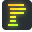

In [8]:
%%pyinstrument

forecaster.fit(series=series_dict, exog=exog_dict)

In [9]:
# Profiling fit()
# ==============================================================================
def funt_to_profile(forecaster, series, exog):
    forecaster.fit(series=series, exog=exog)

%lprun -f forecaster.fit funt_to_profile(forecaster, series_dict, exog_dict)

Timer unit: 1e-09 s

Total time: 5.57935 s
File: /home/ximo/GitHub/skforecast/skforecast/recursive/_forecaster_recursive_multiseries.py
Function: fit at line 1637

Line #      Hits         Time  Per Hit   % Time  Line Contents
  1637                                               def fit(
  1638                                                   self,
  1639                                                   series: pd.DataFrame | dict[str, pd.Series | pd.DataFrame],
  1640                                                   exog: pd.Series | pd.DataFrame | dict[str, pd.Series | pd.DataFrame] | None = None,
  1641                                                   store_last_window: bool | list[str] = True,
  1642                                                   store_in_sample_residuals: bool = False,
  1643                                                   random_state: int = 123,
  1644                                                   suppress_warnings: bool = False
  1645              

In [10]:
# Profiling _create_train_X_y()
# ==============================================================================
def funt_to_profile(forecaster, series, exog):
    forecaster._create_train_X_y(series=series, exog=exog)

%lprun -f forecaster._create_train_X_y funt_to_profile(forecaster, series_dict, exog_dict)

Timer unit: 1e-09 s

Total time: 0.788221 s
File: /home/ximo/GitHub/skforecast/skforecast/recursive/_forecaster_recursive_multiseries.py
Function: _create_train_X_y at line 961

Line #      Hits         Time  Per Hit   % Time  Line Contents
   961                                               def _create_train_X_y(
   962                                                   self,
   963                                                   series: pd.DataFrame | dict[str, pd.Series | pd.DataFrame],
   964                                                   exog: pd.Series | pd.DataFrame | dict[str, pd.Series | pd.DataFrame] | None = None,
   965                                                   store_last_window: bool | list[str] = True,
   966                                               ) -> tuple[
   967                                                   pd.DataFrame,
   968                                                   pd.Series,
   969                                                   

In [11]:
# Profiling _create_train_X_y_single_series()
# ==============================================================================
def funt_to_profile(forecaster, series, exog):
    (
    X_train_autoreg,
    X_train_window_features_names_out_,
    X_train_exog,
    y_train
) = forecaster._create_train_X_y_single_series(
        y = series,
        exog = exog,
        ignore_exog = False,
    )

%lprun -f forecaster._create_train_X_y_single_series funt_to_profile(forecaster, series_dict['series_0'], exog_dict['series_0'])

Timer unit: 1e-09 s

Total time: 0.0023337 s
File: /home/ximo/GitHub/skforecast/skforecast/recursive/_forecaster_recursive_multiseries.py
Function: _create_train_X_y_single_series at line 836

Line #      Hits         Time  Per Hit   % Time  Line Contents
   836                                               def _create_train_X_y_single_series(
   837                                                   self,
   838                                                   y: pd.Series,
   839                                                   ignore_exog: bool,
   840                                                   exog: pd.DataFrame | None = None
   841                                               ) -> tuple[pd.DataFrame, list[str], pd.DataFrame, pd.Series]:
   842                                                   """
   843                                                   Create training matrices from univariate time series and exogenous
   844                                                

In [ ]:
# Profiling predict()
# ==============================================================================
def funt_to_profile(forecaster, steps, exog):
    forecaster.predict(steps=steps, exog=exog, suppress_warnings=True)

%lprun -f forecaster.predict funt_to_profile(forecaster, 7, exog_dict_valid)

Timer unit: 1e-09 s

Total time: 36.6131 s
File: /home/ubuntu/varios/skforecast/skforecast/ForecasterAutoregMultiSeries/ForecasterAutoregMultiSeries.py
Function: predict at line 1537

Line #      Hits         Time  Per Hit   % Time  Line Contents
  1537                                               def predict(
  1538                                                   self,
  1539                                                   steps: int,
  1540                                                   levels: Optional[Union[str, list]]=None,
  1541                                                   last_window: Optional[pd.DataFrame]=None,
  1542                                                   exog: Optional[Union[pd.Series, pd.DataFrame, dict]]=None,
  1543                                                   suppress_warnings: bool=False
  1544                                               ) -> pd.DataFrame:
  1545                                                   """
  1546                

: 

: 

: 

In [ ]:
# Functions to profile:
# ==============================================================================
# check_preprocess_exog_multiseries
# align_series_and_exog_multiseries
# _create_train_X_y_single_series
# _create_predict_inputs
# _recursive_predict

: 

: 

In [ ]:
# Profiling align_series_and_exog_multiseries()
# ==============================================================================
# def funt_to_profile(series_dict, input_series_is_dict, exog_dict):
#     align_series_and_exog_multiseries(
#         series_dict=series_dict,
#         input_series_is_dict=input_series_is_dict,
#         exog_dict = exog_dict,
#     )

# %lprun -f align_series_and_exog_multiseries funt_to_profile(series_dict_train, True, exog_dict_train)

: 

: 

In [ ]:
# # Profiling check_preprocess_exog_multiseries()
# # ==============================================================================
# series_indexes = {k: v.index for k, v  in series_dict_train.items()}
# series_col_names = list(series_dict_train.keys())

# def funt_to_profile(input_series_is_dict, series_indexes, series_col_names, exog, exog_dict):
#     check_preprocess_exog_multiseries(
#         input_series_is_dict = input_series_is_dict,
#         series_indexes = series_indexes,
#         series_col_names = series_col_names,
#         exog = exog_dict_train,
#         exog_dict = exog_dict_train,
#     )

# %lprun -f check_preprocess_exog_multiseries funt_to_profile(True, series_indexes, series_col_names, exog, exog_dict)

: 

: 

In [ ]:
import pandas as pd
import numpy as np
import time

def fun_original():
    pass

def fun_optimized_1():
    pass

start_time = time.time()
try:
    fun_original()
except TypeError as e:
    end_time = time.time()
    print(e)
finally:
    end_time = time.time()
print(f"Original code execution time: {end_time - start_time} seconds")

start_time = time.time()
try:
    fun_optimized_1()
except TypeError as e:
    end_time = time.time()
    print(e)
finally:
    end_time = time.time()
print(f"Optimized code 1 execution time: {end_time - start_time} seconds")


Original code execution time: 0.00015878677368164062 seconds
Optimized code 1 execution time: 0.00017976760864257812 seconds


: 

: 

In [31]:
import numpy as np
import time
from sklearn.preprocessing import OrdinalEncoder
import numpy as np

class FastOrdinalEncoder:
    """
    Encode categorical features as an integer array. The input to this transformer should
    be an array-like of integers or strings, denoting the values taken on by categorical
    (discrete) features. The features are converted to ordinal integers. This results in
    a single column of integers (0 to n_categories - 1) per feature.

    Parameters
    ----------

    Attributes
    ----------
    categories_ : np.ndarray
        Unique categories in the data.
    category_map_ : dict
        Mapping of categories to integers.
    inverse_category_map_ : dict
        Mapping of integers to categories.
    unknown_value : int | float, default=-1
        Value to use for unknown categories.
    
    """


    def __init__(self, unknown_value: int | float = -1):

        self.unknown_value = unknown_value
        self.categories_ = None
        self.category_map_ = None
        self.inverse_category_map_ = None
        
    def fit(self, X: np.ndarray | pd.Series) -> None:
        """
        Fit the encoder to the unique categories in the data.

        Parameters
        ----------
        X : np.ndarray | pd.Series
            Input data to fit the encoder.
        """

        self.categories_ = np.unique(X)
        self.category_map_ = {category: idx for idx, category in enumerate(self.categories_)}
        self.inverse_category_map_ = {idx: category for idx, category in enumerate(self.categories_)}
    
    def transform(self, X: np.ndarray | pd.Series) -> np.ndarray:
        """
        Transform the data to ordinal values using direct indexing.

        Parameters
        ----------
        X : np.ndarray | pd.Series
            Input data to transform.

        Returns
        -------
        np.ndarray
            Transformed data with ordinal values.

        """

        if self.categories_ is None:
            raise ValueError("The encoder has not been fitted yet. Call 'fit' before 'transform'.")
        if not isinstance(X, (np.ndarray, pd.Series)):
            raise ValueError("Input data must be a numpy array or pandas Series.")
        
        encoded_data = pd.Series(X).map(self.category_map_).fillna(self.unknown_value).to_numpy()

        return encoded_data

    def fit_transform(self, X: np.ndarray | pd.Series) -> np.ndarray:
        """
        Fit encoder and transform the data.
        
        Parameters
        ----------
        X : np.ndarray | pd.Series
            Input data to fit and transform.

        Returns
        -------
        np.ndarray
            Transformed data with ordinal values.
        """

        self.fit(X)
        
        return self.transform(X)
    
    def inverse_transform(self, X: np.ndarray | pd.Series) -> np.ndarray:
        """
        Inverse transform the encoded data back to original categories.

        Parameters
        ----------
        X : np.ndarray | pd.Series
            Encoded data to inverse transform.

        Returns
        -------
        np.ndarray
            Inverse transformed data with original categories.
        """
        if self.categories_ is None:
            raise ValueError("The encoder has not been fitted yet. Call 'fit' before 'inverse_transform'.")
        if not isinstance(X, (np.ndarray, pd.Series)):
            raise ValueError("Input data must be a numpy array or pandas Series.")
        
        inverse_encoded_data = pd.Series(X).map(self.inverse_category_map_).fillna(self.unknown_value).to_numpy()

        return inverse_encoded_data
    

# Create a large synthetic dataset of strings (categories)
np.random.seed(42)
categories = [f"category_{i}" for i in range(500)]
data = np.repeat(categories, 1000)
# Benchmark sklearn OrdinalEncoder
start_time = time.time()
sklearn_encoder = OrdinalEncoder()
sklearn_encoded_data = sklearn_encoder.fit_transform(data.reshape(-1, 1))
sklearn_time = time.time() - start_time
print(f"Sklearn OrdinalEncoder time: {sklearn_time:.4f} seconds")

# Benchmark FastOrdinalEncoder
start_time = time.time()
fast_encoder = FastOrdinalEncoder()
fast_encoded_data = fast_encoder.fit_transform(data)
fast_time = time.time() - start_time
print(f"FastOrdinalEncoder time: {fast_time:.4f} seconds")


# Check if the results are the same
assert np.array_equal(sklearn_encoded_data.flatten(), fast_encoded_data)
print("All encoders produced the same results.")

# check inverse transform
assert np.array_equal(data, fast_encoder.inverse_transform(fast_encoded_data))
print("Inverse transform works correctly.")



Sklearn OrdinalEncoder time: 0.3073 seconds
FastOrdinalEncoder time: 0.1347 seconds
All encoders produced the same results.
Inverse transform works correctly.


In [24]:
len(data)

500000